<a href="https://colab.research.google.com/github/hugolopg/desafio_data_DG/blob/main/Rede_desafio_DG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio Digital Grid
Este desafio consiste em criar um modelo capaz de prever a Energia Ativa kWh.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/hugolopg/desafio_data_DG/e2b68015c6544446d5b268514f158b4e7347ad1f/data.csv'
bd = pd.read_csv(url)

bd = bd.interpolate(method='pchip')

bd.describe()

,Energia Ativa kWh,Energia Ativa Ponta kWh,Energia Ativa Fora Ponta kWh,Demanda Ativa kW,Demanda Ativa Ponta kW,Demanda Ativa Fora Ponta kW
count,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000
mean,97.999863,0.567875,97.416689,391.999450,2.271500,389.666758
std,115.746824,6.163242,116.059609,462.987296,24.652969,464.238437
min,-1.470000,-1.470000,-1.470000,-5.880000,-5.880000,-5.880000
25%,-1.260000,0.000000,-1.260000,-5.040000,0.000000,-5.040000
50%,-0.630000,0.000000,0.000000,-2.520000,0.000000,0.000000
75%,242.760000,0.000000,242.760000,971.040000,0.000000,971.040000
max,261.240000,110.670000,261.240000,1044.960000,442.680000,1044.960000


<function matplotlib.pyplot.show>

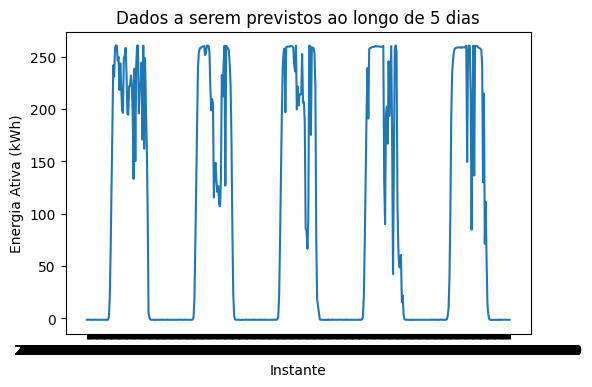

In [22]:
ener = bd.head(480)['Energia Ativa kWh']
inst = bd.head(480)['Instante']

plt.figure(dpi=100)
plt.plot(inst,ener)
plt.title('Dados a serem previstos ao longo de 5 dias')
plt.ylabel('Energia Ativa (kWh)')
plt.xlabel('Instante')
plt.show

Ao fazer uma análise rápida dos dados, verificou-se que havia dados faltantes que foram preenchidos com a biblioteca do pandas. A energia ativa tem média de 98 kWh e tem desvio padrão alto (116 kWh) como esperado de uma usina solar, que sua produção aumenta no período do dia e diminui no período da noite. Nota-se que a produção não foi suficiente para suprir o gasto dos equipamentos da função em mais da metade do tempo, pois metade dos valores estão abaixo de -0,63 kWh, o que é esperado devido ao ciclo de dia/noite. Entretanto, o desligamento à noite poderia trazer esse número mais próximo de 0, reduzindo as perdas.

## RNN
Utilizando abaixo um modelo baseado em RNN (pois utiliza as saídas passadas como entrada) e um layer de LSTM. Esse modelo foi escolhido pois já tenho esperiência com este modelo e é um dos melhores para problemas de regressão.

Inicialmente os dados faltantes foram preenchidos com a função interpolate da biblioteca pandas, utilizando o método PCHIP que se aproxima da interpolação linear mas com curvas mais suaves.

Então o banco de dados foi separado em treino e validação, para que possa detectar caso haja overfitting e criar um modelo mais generalista.

O melhor modelo treinado é salvo, entretanto, apenas temporariamente por se tratar do colab, mas bastaria conectar o colab ao google drive pra salvar automaticamente em definitivo.

Input shape: (32, 96, 6)
Target shape: (32, 1)


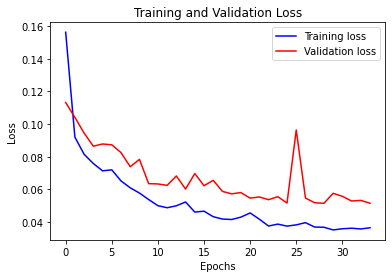

O erro percentual absoluto médio foi de: 22.79%
Input shape: (32, 96, 6)
Target shape: (32, 1)


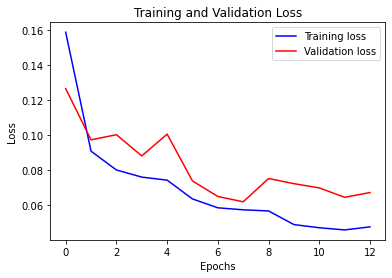

O erro percentual absoluto médio foi de: 103.07%
Input shape: (32, 96, 6)
Target shape: (32, 1)


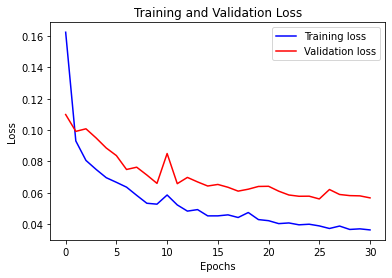

O erro percentual absoluto médio foi de: 46.58%


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

def desnormalizar(data, train_split, normal):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return normal*data_std+data_mean

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        if i==1:
          desejado = plot_data[i]
          print(desejado)
        if i==2:
          previsto = plot_data[i]
          print(previsto)
    erro = abs(previsto-desejado)/desejado
    plt.legend()
    plt.xlim([time_steps[0], (future + 5)])
    plt.ylim([0, max(max(plot_data[0].flatten()),plot_data[1],plot_data[2])*1.1])
    plt.xlabel("Time-Step")
    plt.show()
    return erro

url = 'https://raw.githubusercontent.com/hugolopg/desafio_data_DG/e2b68015c6544446d5b268514f158b4e7347ad1f/data.csv'
bd = pd.read_csv(url)
bd = bd.interpolate(method='pchip') # Interpolando dados faltantes (PCHIP é próximo a linear com uma curva mais suave)

recursos = list(bd)[2:] # dados para previsão

train_split = 2400 # Índice da primeira amostra do dia 26
step = 1

past = 96 # Número de dados do passado a ser testado (próximo a 1 dia de dados, 
          # onde se espera que o padrão de incidência de raios solares se repete)
future = 1  # Amostras no futuro a ser previsto
learning_rate = 0.001
batch_size = 32 # Nº de dados a ser passado para treino antes do recálculo dos parâmetros
epochs = 100 # Épocas de treinamento
features = bd[recursos] 
features.index = bd['Instante']
features.head()
neurons = range(224,289,32) # Números de neurônios da LSTM a ser testado

features = normalize(bd[recursos], train_split) # Normalização z-score
features = pd.DataFrame(features)
features.head()

# Separação de teste e validação
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

menor = np.Inf
for neuron in neurons:

  start = past + future
  end = start + train_split

  x_train = train_data[[i for i in recursos[:]]].values
  y_train = features.iloc[start:end][['Energia Ativa kWh']]

  sequence_length = int(past / step)

  dataset_train = keras.preprocessing.timeseries_dataset_from_array(
      x_train,y_train,
      sequence_length=sequence_length,
      sampling_rate=step,
      batch_size=batch_size,
  )

  x_end = len(val_data) - past - future

  label_start = train_split + past + future

  x_val = val_data.iloc[:x_end][[i for i in recursos[:]]].values
  y_val = features.iloc[label_start:][['Energia Ativa kWh']]

  dataset_val = keras.preprocessing.timeseries_dataset_from_array(
      x_val,y_val,
      sequence_length=sequence_length,
      sampling_rate=step,
      batch_size=batch_size,
  )

  for batch in dataset_train.take(1):
    inputs, targets = batch

  print("Input shape:", inputs.numpy().shape)
  print("Target shape:", targets.numpy().shape)

  inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2])) # Layer de entrada
  lstm_out = keras.layers.LSTM(neuron)(inputs) # Layer LSTM
  dropout = keras.layers.Dropout(0.35)(lstm_out) # Layer dropout
  outputs = keras.layers.Dense(1)(dropout) # Layer saída

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.5), loss="mse") # mse como métrica de treino
  #model.summary()

  path_checkpoint = "model_checkpoint.h5"
  es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

  modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=0,
      save_weights_only=True,
      save_best_only=True,
  )

  history = model.fit(
      dataset_train,
      epochs=epochs,
      validation_data=dataset_val,
      verbose=0,
      callbacks=[es_callback, modelckpt_callback],
  )

  visualize_loss(history, "Training and Validation Loss")
  
  EPAM = 0
  for x, y in dataset_val:
    xd = desnormalizar(bd[recursos], train_split, x)
    yd = desnormalizar(bd['Energia Ativa kWh'], train_split, y)
    pd = desnormalizar(bd['Energia Ativa kWh'], train_split, model.predict(x)[0])
    #show_plot([xd[0][:,-1].numpy(), yd[0].numpy(), pd],future,"Single Step Prediction")
    EPAM += abs(pd-yd[0])/(abs(yd[0])*len(dataset_val)) # Avaliando por outra métrica
  print('O erro percentual absoluto médio foi de: %.2f%%' %(EPAM*100))
  if EPAM<menor:
    menor=EPAM
    melhorModel = model
    validacao = dataset_val
    treino = train_split
np.save('erro_treino.npy',
        [menor, treino], allow_pickle=True)
melhorModel.save('modelo.h5')
tf.data.experimental.save(validacao,'validacao.h5', 
                          compression=None, shard_func=None, checkpoint_args=None)

[-1.26]
[-0.6063843]


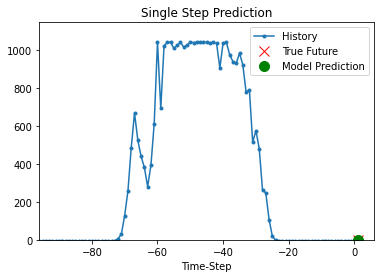

[170.31]
[149.27362]


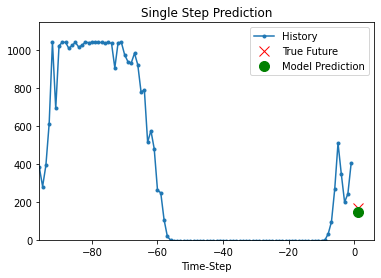

[203.49]
[219.0252]


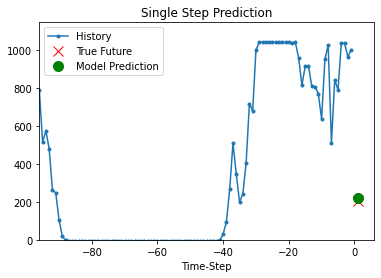

[-1.26]
[-0.59980774]


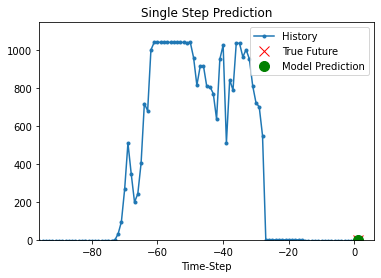

[257.67]
[233.27463]


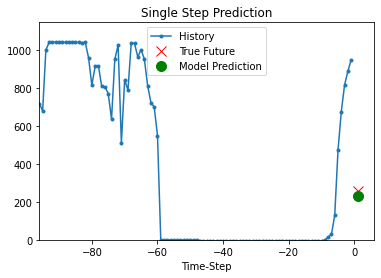

In [18]:
[menor, treino] = np.load('erro_treino.npy',allow_pickle=True)
melhorModel = keras.models.load_model('modelo.h5')
validacao = tf.data.experimental.load('validacao.h5', 
                          element_spec=None, compression=None, reader_func=None)
EPAM = 0
for x, y in validacao.take(5):
  xd = desnormalizar(bd[recursos], treino, x)
  yd = desnormalizar(bd['Energia Ativa kWh'], treino, y)
  pd = desnormalizar(bd['Energia Ativa kWh'], treino, melhorModel.predict(x)[0])
  erro = show_plot([xd[0][:,-1].numpy(), yd[0].numpy(), pd],future,"Single Step Prediction")
  #EPAM += abs(pd-yd[0])/(yd[0]*len(dataset_val))
  #EPAM += erro/len(validacao)
#print('O erro percentual absoluto médio foi de: %.2f%%' %(EPAM*100))

Aqui no final estão apresentados algumas das previsões da validação, a métrica do erro percentual ajuda a ter noção da proporção do erro em relação ao tamanho da saída, entretando a desvantagem é que este erro aumenta quando se prevê os menores valores do banco de dados.

A busca de parâmetros foi focada no número de neurônios da LSTM pois esse parâmetro que vai ditar capacidade da rede de reter informação além do número de amostras do passado. Como é bom ter pelo menos um dia (período de repetição), sobrou o outro parâmetro a ser buscado.

Por fim, a rede foi capaz de prever a Energia Ativa kWh com erro de 23%, sendo possível avaliar a necessidade de tomar ações caso a energia não seja suficiente para suprir alguma demanda prevista ou reduzir a produção caso a demanda seja superior à demanda.